In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import scipy.stats as stats
from sklearn.model_selection import cross_validate, ShuffleSplit,train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm
import sklearn.metrics as metrics
from sklearn.metrics import mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.dummy import DummyRegressor

%matplotlib inline

#DummyRegressor
#SimpleImputer

In [6]:
!ls ../data

column_names.md
kc_house_data.csv


In [10]:
with open('../data/column_names.md') as f:
    text = f.read()
print(text)

# Column Names and descriptions for Kings County Data Set
* **id** - unique identified for a house
* **dateDate** - house was sold
* **pricePrice** -  is prediction target
* **bedroomsNumber** -  of Bedrooms/House
* **bathroomsNumber** -  of bathrooms/bedrooms
* **sqft_livingsquare** -  footage of the home
* **sqft_lotsquare** -  footage of the lot
* **floorsTotal** -  floors (levels) in house
* **waterfront** - House which has a view to a waterfront
* **view** - Has been viewed
* **condition** - How good the condition is ( Overall )
* **grade** - overall grade given to the housing unit, based on King County grading system
* **sqft_above** - square footage of house apart from basement
* **sqft_basement** - square footage of the basement
* **yr_built** - Built Year
* **yr_renovated** - Year when house was renovated
* **zipcode** - zip
* **lat** - Latitude coordinate
* **long** - Longitude coordinate
* **sqft_living15** - The square footage of interior housing living space for the neares

# Agreed upon cleaned dataset

In [3]:
dataset = pd.read_csv('data/kc_house_data.csv')

# Null waterfront values count as no waterfront
dataset['waterfront'] = dataset['waterfront'].fillna(0) 

dataset['date'] = pd.to_datetime(dataset['date'])
# Drop how many times house viewed
dataset.dropna(subset = ['view'], inplace = True)
# Make values with no house renovation the year it was built
dataset.yr_renovated.fillna(dataset.yr_built, inplace=True)
# Make Zipcode a str
dataset['zipcode'].astype(int)
# Make sqft basement a float and fill na with 0
dataset['sqft_basement'] = dataset['sqft_basement'].replace('?', np.nan).astype(float).fillna(0)


In [5]:
dataset['date'].min(), dataset['date'].max()

(Timestamp('2014-05-02 00:00:00'), Timestamp('2015-05-27 00:00:00'))

In [161]:
#Load in data
df_train = pd.read_csv('data/kc_house_data.csv') 
df_test = pd.read_csv('data/kc_house_data.csv')
df = pd.read_csv('data/kc_house_data.csv')


df['beds_baths'] = df['bedrooms'] + df['bathrooms']
df['waterfront'] = df['waterfront'].fillna(0)
df['sqft_basement'] = df['sqft_basement'].replace('?',np.nan).astype(float).fillna(0)
df['zipcode'] = df['zipcode'].apply(str)
df = df.drop(['id','date','view'],axis=1)
df.yr_renovated.fillna(df.yr_built, inplace=True)


# Create a Dummy Dataframe then join to our main one

In [162]:

dummy_df = dataset['grade']
dummies = pd.get_dummies(dummy_df,prefix='grade',drop_first=True)
merged = pd.concat([dataset,dummies],axis=1)
merged.isna().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
grade_4          0
grade_5          0
grade_6          0
grade_7          0
grade_8          0
grade_9          0
grade_10         0
grade_11         0
grade_12         0
grade_13         0
dtype: int64

# A look at how data is distributed

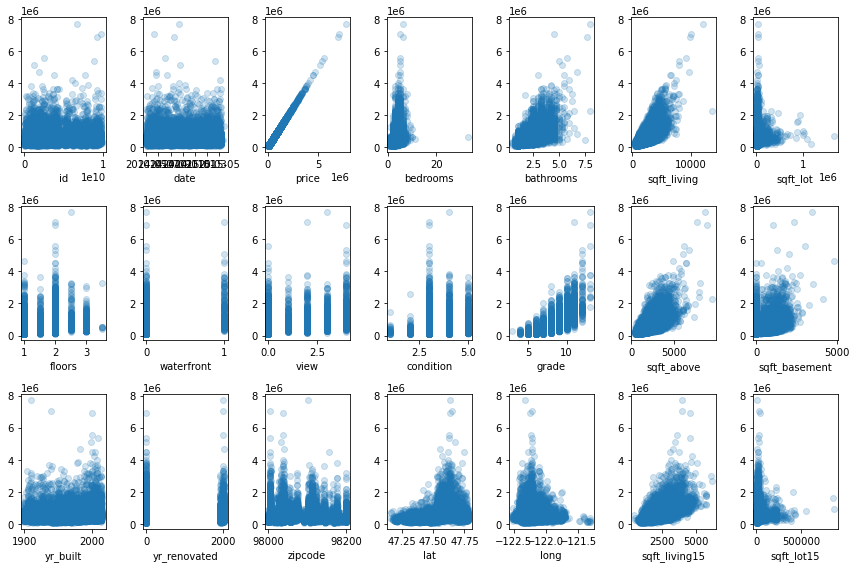

In [5]:
fig , axes = plt.subplots(nrows=3,ncols=7,figsize=(12,8))
fig.set_tight_layout(True)

for index,col in enumerate(dataset.columns):
    ax = axes[index//7][index%7]
    ax.scatter(dataset[col],dataset['price'],alpha=.2)
    ax.set_xlabel(col)

# Heatmap for a quick look at where we might start

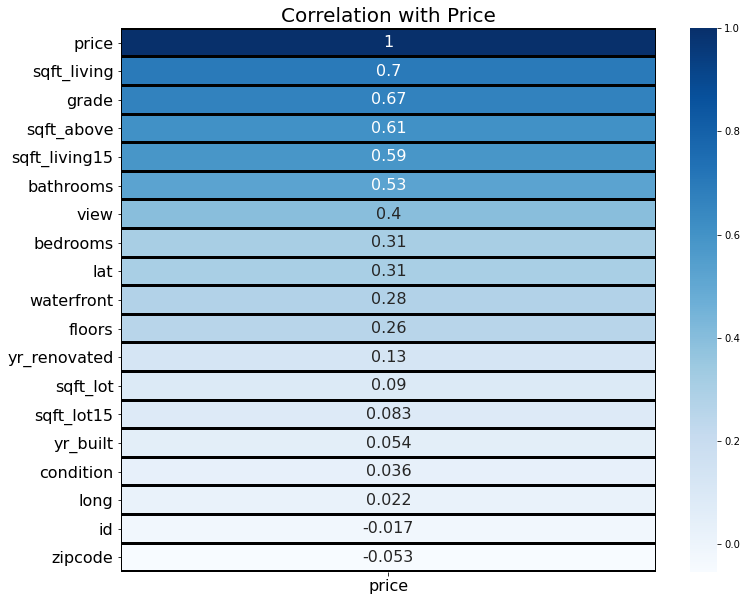

In [6]:
corr = df_train.corr()

x=corr[['price']]

fig , ax = plt.subplots(figsize=(12,10))

sns.heatmap(x.sort_values(by=['price'],ascending=0),
                          annot=True,
                          cmap='Blues',
                          annot_kws={'fontsize':16},
                          linewidth=2,
                          linecolor='black')
ax.set_title('Correlation with Price',size=20)
ax.tick_params(labelsize=16)
                          


 It seems like sqft_living has the highest correlation with price. This and grade seem to be the two highest, but grade is categorical (technically) and sqft is numerical.

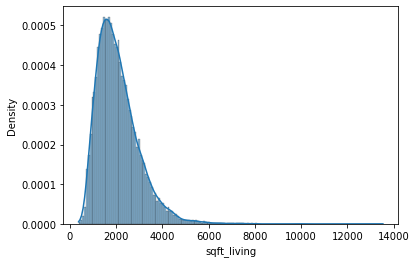

In [7]:
sns.histplot(df['sqft_living'],stat='density',kde=1);


Our data is skewed to the left.

In [163]:
df_zip = df.groupby('zipcode').mean().sort_values(by=['price'],ascending=False)
columns = ['price','bedrooms','bathrooms','sqft_living','sqft_lot','condition','grade','sqft_living15','sqft_lot15']
new_df = pd.DataFrame(df_zip,columns=columns)
#new_df['avg_price_zipcode'] = df['zipcode'].map(lambda x: df['price'][x].mean())
price_df = new_df['price']
d = price_df.to_dict()
d

{'98039': 2161300.0,
 '98004': 1356523.9905362776,
 '98040': 1194873.6382978724,
 '98112': 1096239.0074349442,
 '98102': 899607.6730769231,
 '98109': 880077.752293578,
 '98105': 863228.9432314411,
 '98006': 859938.5542168674,
 '98119': 849714.8097826086,
 '98005': 810289.6964285715,
 '98033': 803990.8194444445,
 '98199': 792187.8738170346,
 '98075': 790734.704735376,
 '98074': 685675.8435374149,
 '98077': 682885.9898989899,
 '98053': 677215.034739454,
 '98177': 676419.3921568628,
 '98008': 645628.2261484099,
 '98052': 645244.2264808363,
 '98122': 634558.1448275862,
 '98115': 619944.1492281304,
 '98116': 618695.1090909091,
 '98007': 617254.0212765958,
 '98027': 617053.9660194175,
 '98029': 612642.738317757,
 '98144': 594706.5422740525,
 '98024': 586120.875,
 '98103': 585048.7790697674,
 '98107': 579109.8082706766,
 '98117': 576834.808318264,
 '98072': 570073.5201465201,
 '98136': 551768.5209125475,
 '98065': 529629.7824675324,
 '98034': 521740.0146788991,
 '98059': 493625.3098290598,
 '

In [164]:
df_grade = df.groupby('grade').mean().sort_values(by=['price'],ascending=False)
grade_df = pd.DataFrame(df_grade,columns=columns)
grade_df


,price,bedrooms,bathrooms,sqft_living,sqft_lot,condition,grade,sqft_living15,sqft_lot15
grade,,,,,,,,,
13,3.710769e+06,4.846154,5.096154,7483.076923,28204.769231,3.153846,NaN,4005.384615,25529.461538
12,2.202528e+06,4.269663,4.025281,5479.022472,54819.213483,3.213483,NaN,3955.988764,39134.078652
11,1.497792e+06,4.160401,3.501880,4395.448622,38372.789474,3.195489,NaN,3532.110276,27743.160401
10,1.072347e+06,3.907407,3.006393,3520.299824,28191.063492,3.232804,NaN,3036.892416,21334.663139
9,7.737382e+05,3.773231,2.664340,2868.139962,20638.515488,3.266157,NaN,2613.460038,17401.707839
8,5.429868e+05,3.481616,2.348928,2184.803627,13514.009068,3.355647,NaN,2067.075845,11371.257049
7,4.025946e+05,3.258079,1.829953,1689.514932,11769.877089,3.491420,NaN,1679.280254,10615.995988
6,3.019166e+05,2.685967,1.243499,1191.561335,12646.953876,3.539745,NaN,1389.247301,11020.924926
3,2.620000e+05,1.000000,0.750000,520.000000,12981.000000,5.000000,NaN,1340.000000,12233.000000


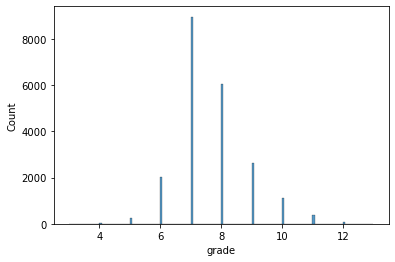

In [10]:
sns.histplot(df['grade']);

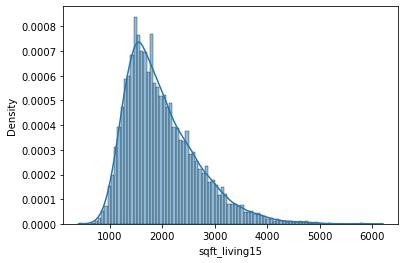

In [11]:
sns.histplot(df['sqft_living15'],stat='density',kde=1);

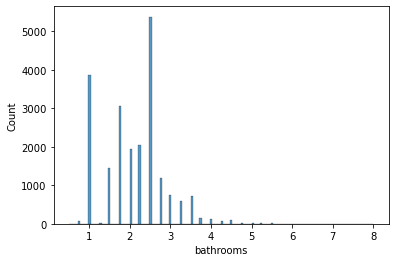

In [12]:
sns.histplot(df['bathrooms']);

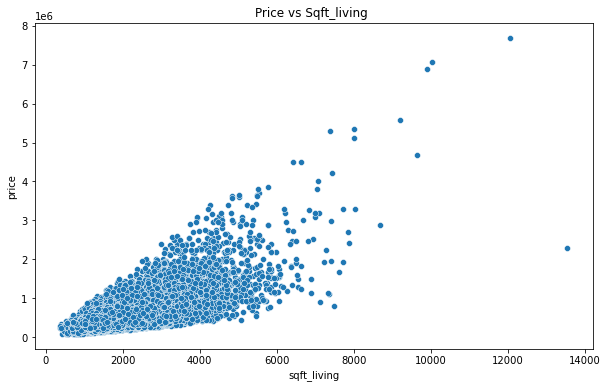

In [13]:
fig , (ax) = plt.subplots(figsize=(10,6))
ax.set_title('Price vs Sqft_living ')
sns.scatterplot(x=df['sqft_living'],y=df['price']);

Price and sqft_living seem to have a linear relationship based on this data.

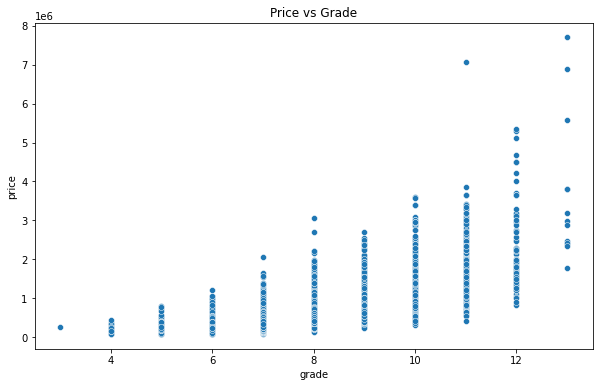

In [14]:
fig , (ax) = plt.subplots(figsize=(10,6))
ax.set_title('Price vs Grade')

sns.scatterplot(x=df['grade'],y=df['price']);

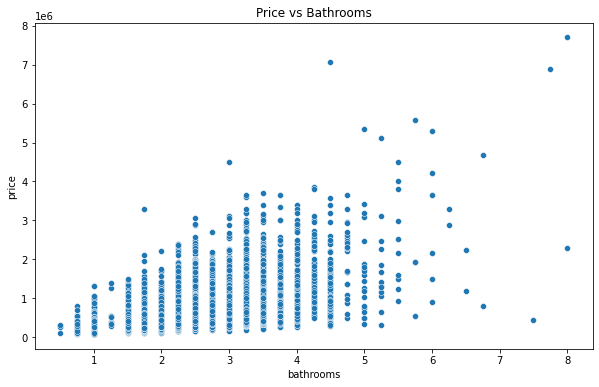

In [15]:
fig , (ax) = plt.subplots(figsize=(10,6))
ax.set_title('Price vs Bathrooms')

sns.scatterplot(x=df['bathrooms'],y=df['price']);

# Looking at score with most correlated feature

In [16]:
X = df_train['sqft_living']
y= df_train['price']
X_train,X_test,Y_train,Y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = np.array(X_train).reshape(-1,1)
Y_train = np.array(Y_train).reshape(-1,1)
X_test = np.array(X_test).reshape(-1,1)
Y_test = np.array(Y_test).reshape(-1,1)


model = LinearRegression()
model.fit(X_train,Y_train)

Y_pred = model.predict(X_test)

model.coef_,model.intercept_,model.score(X_train,Y_train),metrics.r2_score(Y_pred,Y_test)

(array([[282.20150555]]),
 array([-46447.34551807]),
 0.49249290659878187,
 0.02163804095839439)

In [17]:
#formula = 'price ~ sqft_living + beds_baths +  grade_5 + grade_6 +  grade_8 + grade_9 +grade_10+grade_11+grade_12+grade_13' 
#model = ols(formula, data=merged)
#model.fit().summary()

Our first model uses one feature and can explain 49.2% of price variances. Y= 282.20*sqft - 46447 R2 = 49.2

In [18]:
X = pd.DataFrame(df,columns = ['sqft_living','grade'])
y = df['price']


In [19]:
X_train,X_test,Y_train,Y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Scaler = StandardScaler()
X_train = Scaler.fit(X_train).transform(X_train)

model = LinearRegression()
model.fit(X_train,Y_train)

y_hat = model.predict(X_train)

resid = Y_train-y_hat

Y_pred = model.predict(Scaler.transform(X_test))

model.coef_,model.intercept_,model.score(X_train,Y_train) , metrics.r2_score(Y_pred,Y_test) 


(array([168211.94618026, 119172.30259603]),
 541519.0094345083,
 0.5363690098946963,
 0.1760240478124543)

In [20]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif

,VIF Factor,features
0,10.451144,sqft_living
1,10.451144,grade


In [21]:
formula2 = 'price ~ sqft_living + grade '
model = ols(formula2, data=df_train)
model.fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.535
Model:                            OLS   Adj. R-squared:                  0.535
Method:                 Least Squares   F-statistic:                 1.241e+04
Date:                Thu, 26 Aug 2021   Prob (F-statistic):               0.00
Time:                        08:21:08   Log-Likelihood:            -2.9913e+05
No. Observations:               21597   AIC:                         5.983e+05
Df Residuals:                   21594   BIC:                         5.983e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -6.028e+05   1.33e+04    -45.181      0.000   -6.29e+05   -5.77e+05
sqft_living   184.1215      2.872     64.102      0.000     178.491     189.751
grade        9.925e+04   2247.784     44.155      0.000    9.48e+04    1.04e+05
==============================================================================
Omnibus:                    16960.955   Durbin-Watson:                   1.976
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1005795.090
Skew:                           3.304   Prob(JB):                         0.00
Kurtosis:                      35.773   Cond. No.                     1.80e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.8e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Our second model uses grade and square feet that gives us a better explanation of variances in price.
*Y= 183.33*sqft + 101962*grade - 621259 
R2 = 54%* 





In [22]:
formula3 = 'price ~ sqft_living + grade + beds_baths + waterfront + condition'
model = ols(formula3, data=df)
model.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.589
Model:                            OLS   Adj. R-squared:                  0.589
Method:                 Least Squares   F-statistic:                     6185.
Date:                Thu, 26 Aug 2021   Prob (F-statistic):               0.00
Time:                        08:21:08   Log-Likelihood:            -2.9779e+05
No. Observations:               21597   AIC:                         5.956e+05
Df Residuals:                   21591   BIC:                         5.956e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -7.571e+05   1.72e+04    -43.905      0.000   -7.91e+05   -7.23e+05
sqft_living   208.6055      3.412     61.130      0.000     201.917     215.294
grade        1.065e+05   2140.052     49.748      0.000    1.02e+05    1.11e+05
beds_baths  -3.012e+04   1662.345    -18.118      0.000   -3.34e+04   -2.69e+04
waterfront   8.233e+05   1.97e+04     41.732      0.000    7.85e+05    8.62e+05
condition    6.097e+04   2500.517     24.384      0.000    5.61e+04    6.59e+04
==============================================================================
Omnibus:                    15518.669   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           847671.770
Skew:                           2.890   Prob(JB):                         0.00
Kurtosis:                      33.142   Cond. No.                     2.80e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.8e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# An early model where we are exploring features

In [23]:
X = pd.DataFrame(df,columns = ['sqft_living','grade','beds_baths','condition'])
y = df['price']

X_train,X_test,Y_train,Y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
ss = StandardScaler()
ss.fit(X).transform(X)

model.fit(X,y)

y_hat = model.predict(X_test)

resid = Y_test-y_hat

model.coef_,model.intercept_,model.score(X_train,Y_train), metrics.r2_score(y_hat,Y_test) 


(array([   221.88004064, 107108.18507951, -35141.75985275,  63421.8738075 ]),
 -764874.2248935248,
 0.5584010704736011,
 0.22173037087376313)

This model performed poorly on the test set.

In [24]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif

,VIF Factor,features
0,16.657437,sqft_living
1,41.340661,grade
2,31.440462,beds_baths
3,18.052397,condition


In [25]:
#ss = StandardScaler()
#ss.fit(x)

#transform = ss.transform(x)
#transform

#lr = LinearRegression()
#lr.fit(x,y)

#y_hat = lr.predict(x)

#resid = (y - y_hat)

#plt.scatter(x=range(y_hat.shape[0]),y=resid, alpha=0.1)

In [26]:
#X_train,X_test,Y_train,Y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:

#model = LinearRegression()
#model.fit(X_train['sqft_living'],Y_train)
#Y_pred = model.predict(X_test)
#model.coef_ , model.intercept_
#mean_squared_error(Y_test,Y_pred) , mean_squared_error(Y_test,Y_pred,squared=False) 


In [28]:
#y_train_hat = lr.predict(X_train)
#mse = mean_squared_error(Y_train,y_train_hat)
#rmse = mean_squared_error(Y_train, y_train_hat, squared=False)
#score = lr.score(X_train,Y_train)
#score

#print(f'Evaluate Model Prediction with Training Dataset:')
#print('------------------------------------------------')
#print(f'Mean Squared Error: {mse}')
#print(f'Root Mean Squared Error: {rmse}')
#print(f'R^2: {score}')

In [29]:
#y_test_hat = lr.predict(X_test)
#mse_test = mean_squared_error(Y_test,y_test_hat)
#rmse_test = mean_squared_error(Y_test,y_test_hat,squared=False)
#r2_test = lr.score(X_test,Y_test)

#print(f'Evaluate Model Prediction with Testing Dataset:')
#print('------------------------------------------------')
#print(f'Testing Mean Squared Error: {mse_test}')
#print(f'Testing Root Mean Squared Error: {rmse_test}')
#print(f'Testing R^2: {r2_test}')

In [30]:
#For each X, calculate VIF and save in dataframe
#vif = pd.DataFrame()
#vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
#vif["features"] = X.columns


# R2 score with grades as dummy variables

In [31]:
X=merged.drop(['price','id','date','sqft_lot','sqft_above','grade'], axis = 1).select_dtypes(exclude = ['object', 'category'])
y=merged['price']

X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Scaler = StandardScaler()
X_train = Scaler.fit_transform(X_train)
X_test = Scaler.transform(X_test)

baseline_model = LinearRegression()
baseline_model.fit(X_train, y_train)

y_pred = baseline_model.predict(X_test)
baseline_model.coef_, baseline_model.intercept_, baseline_model.score(X_train, y_train), baseline_model.score(X_test, y_test)

(array([-20865.88355014,  34426.3344904 , 119858.61316326,  15609.73584258,
         51616.72805636,  39012.02947916,  18351.17755684,    781.13301792,
        -68554.87537986,   3382.62828067, -33314.47566988,  86218.29410271,
        -28139.50632492,  18885.96953795,  -6991.06907425,  -5862.57998996,
        -16886.24341471, -36025.31542683, -41061.16532166,  -9335.23049358,
         31238.78399154,  58532.37160757,  68878.96790036,  59061.82461275,
         32047.01816981]),
 538633.78405991,
 0.7241205200781611,
 0.7334422926556725)

Explaining variances at 73%, this is our best model we have come up with.

# R2 Score with Grade as Normal

In [53]:
X = dataset.drop(['price','id','date','sqft_lot','sqft_above','view'], axis = 1).select_dtypes(exclude = ['object', 'category'])
#X = X.drop(['id','date','sqft_lot','sqft_above'],axis=1)
y=dataset['price']

X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Scaler = StandardScaler()
X_train = Scaler.fit_transform(X_train)
X_test = Scaler.transform(X_test)

baseline_model = LinearRegression()
baseline_model.fit(X_train, y_train)

y_pred = baseline_model.predict(X_test)
baseline_model.coef_, baseline_model.intercept_, baseline_model.score(X_train, y_train), baseline_model.score(X_test, y_test)

(array([-37609.20194707,  33502.23327256, 154520.81617786,   8194.71499042,
         67357.85145188,  16043.75388149, 119595.2203818 ,  -2522.4633234 ,
        -84745.7706637 ,   2566.70906647, -28203.11581313,  80665.61654846,
        -30829.68916557,  26925.16679933,  -5035.62713527]),
 538633.7840599093,
 0.6933744789788556,
 0.6761336424705153)

This model performs lower on the testing set, meaning the dummy variables helped with our R2.

In [54]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif

,VIF Factor,features
0,2.328013e+01,bedrooms
1,2.832487e+01,bathrooms
2,3.662867e+01,sqft_living
3,1.667134e+01,floors
4,1.033515e+00,waterfront
5,3.391598e+01,condition
6,1.468470e+02,grade
7,2.596895e+00,sqft_basement
8,8.595413e+03,yr_built
9,1.295671e+00,yr_renovated


<AxesSubplot:>

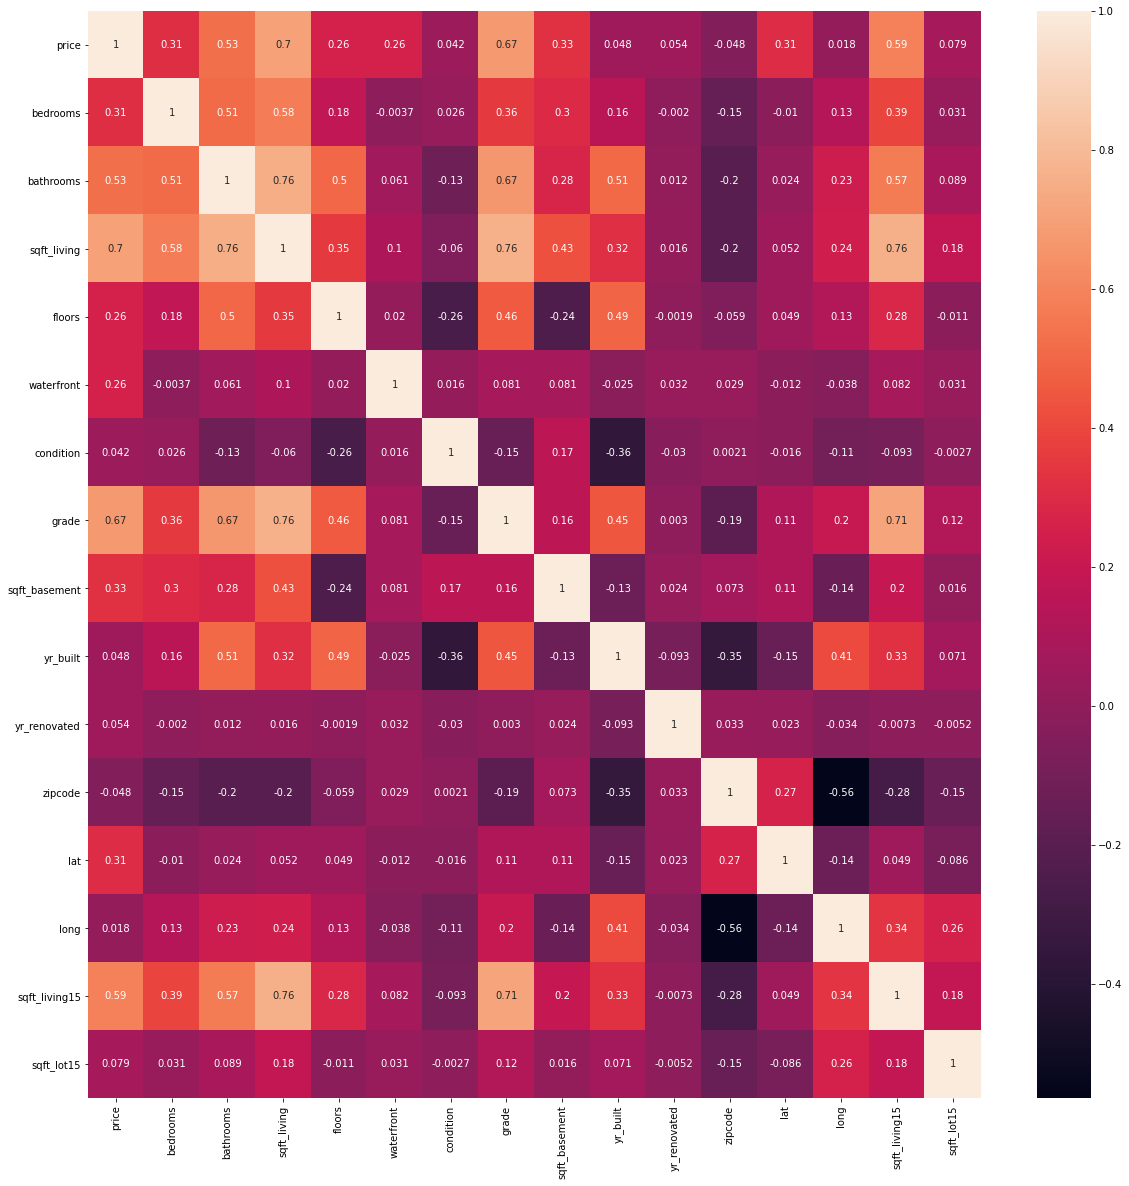

In [34]:
heatmap_data=pd.concat([Y_train,X],axis=1)

fig , ax = plt.subplots(figsize=(20,20))

sns.heatmap(heatmap_data.corr(),annot=True)

In [35]:
X=merged.drop(['price','id','date','sqft_lot','sqft_above','grade','sqft_living15','bathrooms','grade_7'], axis = 1).select_dtypes(exclude = ['object', 'category'])
y=merged['price']

X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Scaler = StandardScaler()
X_train = Scaler.fit_transform(X_train)
X_test = Scaler.transform(X_test)

baseline_model = LinearRegression()
baseline_model.fit(X_train, y_train)

y_pred = baseline_model.predict(X_test)
baseline_model.coef_, baseline_model.intercept_, baseline_model.score(X_train, y_train), baseline_model.score(X_test, y_test)

(array([-16308.09412716, 144292.4051698 ,  20767.49731764,  51149.55545665,
         41314.94142964,  19023.76567917,   2808.43717376, -60339.22672593,
          3944.60438557, -34902.18831611,  87120.88222872, -26562.61808724,
         -7261.96925403,  -2968.45006754,  -8585.10999741, -14091.904898  ,
         32803.25959418,  63366.88402831,  82177.22435801,  84068.66889661,
         66400.98595741,  34560.5110554 ]),
 538633.7840599102,
 0.7205975072079329,
 0.7302976662121338)

In [36]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif

,VIF Factor,features
0,2.369698e+01,bedrooms
1,2.973560e+01,sqft_living
2,1.554200e+01,floors
3,1.186929e+00,waterfront
4,1.494217e+00,view
5,3.399118e+01,condition
6,2.638590e+00,sqft_basement
7,8.158615e+03,yr_built
8,1.294138e+00,yr_renovated
9,1.609357e+06,zipcode


In [182]:
merged = merged[merged['price'] < 1200000]
merged.shape

(20520, 31)

In [183]:


X=merged.drop(['id','date','lat','yr_renovated','long','view','sqft_lot','grade_13','sqft_above','grade','sqft_living15','bathrooms','sqft_lot15','yr_built','bedrooms','sqft_basement','floors','condition'], axis = 1).select_dtypes(exclude = ['object', 'category'])
y=merged['price']

X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=42)

group = X_train.groupby('zipcode').mean().sort_values(by=['price'],ascending=False)
zip_group = group['price']
zip_dict = zip_group.to_dict()
X_train['avg_zip_price'] = X_train['zipcode'].map(zip_dict)


<ipython-input-183-81fea6b28ace>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['avg_zip_price'] = X_train['zipcode'].map(zip_dict)


In [184]:
vif = pd.DataFrame()
X = pd.DataFrame(X_train,columns=X_train.columns)
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns


In [185]:
X_test['avg_zip_price'] = X_test['zipcode'].map(zip_dict)
#X_test['sqft'] = X_train['price'].mean() / X_train['sqft_living'].mean()
X_test.drop('price',inplace=True,axis=1)
X_train.drop('price',inplace=True,axis=1)

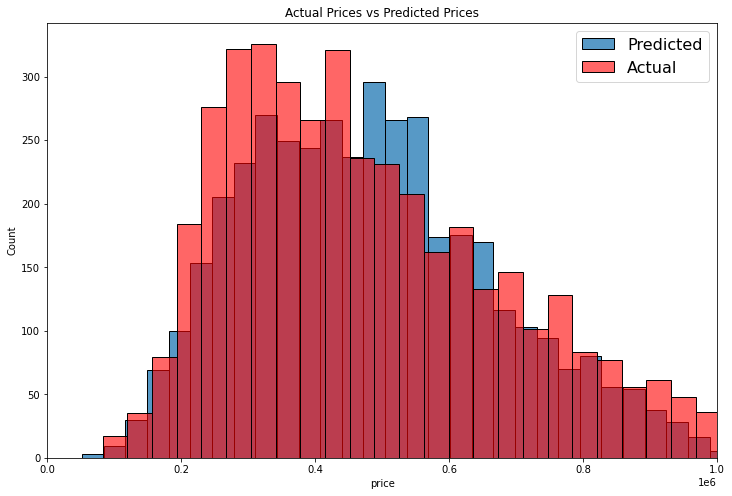

In [186]:
fig , axes = plt.subplots(nrows=1,ncols=1,figsize=(12,8))

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
sns.histplot(y_pred,ax=axes,label='Predicted')
sns.histplot(y_test,color='red',alpha=.6,label='Actual')
axes.set_xlim([0,1000000])
axes.set_xlabel('price')
axes.set_title('Actual Prices vs Predicted Prices')
plt.legend(fontsize=16);
plt.savefig('Predicted vs Actual Stacked')


In [187]:
#X=merged.drop(['price','id','date','sqft_lot','sqft_above','grade','grade_7','sqft_living15','bathrooms','sqft_lot15','lat','long','yr_built','bedrooms','sqft_basement','floors','condition'], axis = 1).select_dtypes(exclude = ['object', 'category'])
#y=merged['price']

#X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Scaler = StandardScaler()
X_train = Scaler.fit_transform(X_train)
X_test = Scaler.transform(X_test)

final_model = LinearRegression()
final_model.fit(X_train, y_train)

y_pred = final_model.predict(X_test)
final_model.coef_, final_model.intercept_, final_model.score(X_train, y_train), final_model.score(X_test, y_test)

(array([ 83222.84286199,  17013.56515105,  24309.81640957,  -5411.45099114,
        -16325.72669674, -43142.96009084, -58638.67682191, -37523.31119604,
         -4554.44347559,   4918.99774156,   9859.0700101 ,    195.85574986,
        118005.11737938]),
 479651.2592592586,
 0.7677288076177324,
 0.7769989117078411)

# Investigating Linearity

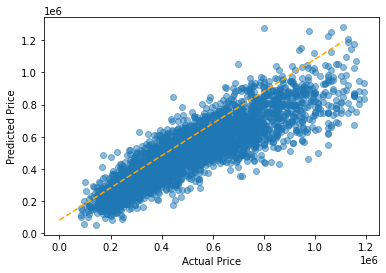

In [189]:
preds = final_model.predict(X_test)
fig, ax = plt.subplots()

perfect_line = np.arange(y_test.min(), y_test.max())
ax.plot(perfect_line, linestyle = '--', color = 'orange', label = "Perfect Fit")
ax.scatter(y_test, preds, alpha=.5)
ax.set_xlabel("Actual Price")
ax.set_ylabel("Predicted Price");


# Investigating Normality

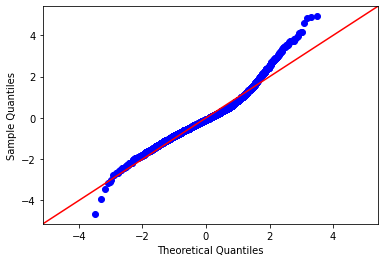

In [190]:
residuals = (y_test - y_pred)
sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True);

# Investigating Homoskedasticity

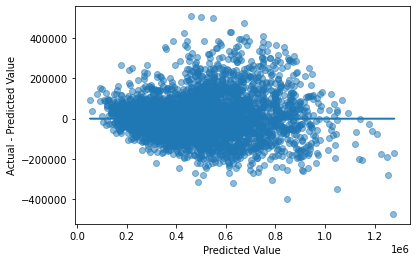

In [191]:
fig, ax = plt.subplots()

ax.scatter(preds, residuals, alpha=0.5)
ax.plot(preds, [0 for i in range(len(X_test))])
ax.set_xlabel("Predicted Value")
ax.set_ylabel("Actual - Predicted Value");

In [217]:
merged['avg_zip_price'] = merged['zipcode'].map(zip_dict)
merged2 = merged
merged2['sqft'] = merged2['price'] / (merged2['sqft_lot'] + merged['sqft_living'])
merged2['bed_baths'] = merged2['price'].mean() / (merged2['bedrooms'].mean()+merged2['bathrooms'].mean())
formula4 = 'price ~ sqft_living + waterfront +  avg_zip_price + grade_5+grade_6+grade_7+grade_8+grade_9+grade_10+grade_11+sqft+bed_baths'
model = ols(formula4, data=merged2)
model.fit().summary()

<ipython-input-217-67725b526f84>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged['avg_zip_price'] = merged['zipcode'].map(zip_dict)
<ipython-input-217-67725b526f84>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged2['sqft'] = merged2['price'] / (merged2['sqft_lot'] + merged['sqft_living'])
<ipython-input-217-67725b526f84>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.786
Model:                            OLS   Adj. R-squared:                  0.785
Method:                 Least Squares   F-statistic:                     6830.
Date:                Thu, 26 Aug 2021   Prob (F-statistic):               0.00
Time:                        10:28:07   Log-Likelihood:            -2.6522e+05
No. Observations:               20520   AIC:                         5.305e+05
Df Residuals:                   20508   BIC:                         5.306e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -1.871e-05    2.2e-06     -8.504      0.000    -2.3e-05   -1.44e-05
sqft_living     121.8409      1.311     92.927      0.000     119.271     124.411
waterfront     3.172e+05   1.31e+04     24.254      0.000    2.92e+05    3.43e+05
avg_zip_price     0.6822      0.006    123.162      0.000       0.671       0.693
grade_5       -2.509e+04   1.84e+04     -1.360      0.174   -6.12e+04    1.11e+04
grade_6       -1.465e+04   1.74e+04     -0.840      0.401   -4.88e+04    1.95e+04
grade_7       -1.625e+04   1.73e+04     -0.937      0.349   -5.02e+04    1.78e+04
grade_8       -3775.9943   1.74e+04     -0.217      0.828   -3.79e+04    3.03e+04
grade_9        5.954e+04   1.76e+04      3.390      0.001    2.51e+04     9.4e+04
grade_10       1.029e+05   1.79e+04      5.754      0.000    6.78e+04    1.38e+05
grade_11       1.814e+05   1.93e+04      9.409      0.000    1.44e+05    2.19e+05
sqft           1000.2421     19.250     51.960      0.000     962.510    1037.974
bed_baths        -1.6693      0.196     -8.504      0.000      -2.054      -1.285
==============================================================================
Omnibus:                     2682.931   Durbin-Watson:                   1.949
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6419.467
Skew:                           0.763   Prob(JB):                         0.00
Kurtosis:                       5.276   Cond. No.                     2.06e+21
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.25e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

# Is it Legal?

In [225]:
merged

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade_7,grade_8,grade_9,grade_10,grade_11,grade_12,grade_13,avg_zip_price,sqft,bed_baths
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,...,1,0,0,0,0,0,0,306629.964444,32.489019,89221.236886
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,1,0,0,0,0,0,0,453272.609756,54.830819,89221.236886
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,0,0,0,0,0,0,0,460932.762712,16.713092,89221.236886
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,1,0,0,0,0,0,0,523591.691919,86.781609,89221.236886
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,0,1,0,0,0,0,0,649372.606936,52.254098,89221.236886
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,2014-05-21,360000.0,3,2.50,1530,1131,3.0,0.0,0.0,...,0,1,0,0,0,0,0,575751.820296,135.287486,89221.236886
21593,6600060120,2015-02-23,400000.0,4,2.50,2310,5813,2.0,0.0,0.0,...,0,1,0,0,0,0,0,342904.216102,49.242891,89221.236886
21594,1523300141,2014-06-23,402101.0,2,0.75,1020,1350,2.0,0.0,0.0,...,1,0,0,0,0,0,0,503249.783784,169.662869,89221.236886
21595,291310100,2015-01-16,400000.0,3,2.50,1600,2388,2.0,0.0,0.0,...,0,1,0,0,0,0,0,572720.054140,100.300903,89221.236886


In [226]:
X=merged.drop(['id','date','lat','bed_baths','yr_renovated','long','view','sqft_lot','grade_13','sqft_above','grade','sqft_living15','sqft_lot15','yr_built','bathrooms','sqft_basement','floors','condition'], axis = 1).select_dtypes(exclude = ['object', 'category'])
y=merged['price']

X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=42)

group = X_train.groupby('zipcode').mean().sort_values(by=['price'],ascending=False)
group2 = X_train.groupby('bedrooms').mean().sort_values(by=['price'],ascending=False)
bedrooms_group = group2['price']
bed_dict = bedrooms_group.to_dict()
X_train['beds'] = X_train['bedrooms'].map(bed_dict)
zip_group = group['price']
zip_dict = zip_group.to_dict()
#X_train['avg_zip_price'] = X_train['zipcode'].map(zip_dict)
#X_train['sqft'] = (X_train['price'] / X_train['sqft_living']).mean()
X_train

<ipython-input-226-4449ddf4a2e7>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['beds'] = X_train['bedrooms'].map(bed_dict)


,price,bedrooms,sqft_living,waterfront,zipcode,grade_4,grade_5,grade_6,grade_7,grade_8,grade_9,grade_10,grade_11,grade_12,avg_zip_price,sqft,beds
10099,920000.0,3,2590,0.0,98074,0,0,0,0,0,1,0,0,0,649372.606936,4.077707,440494.713053
16882,320000.0,4,2070,0.0,98031,0,0,0,1,0,0,0,0,0,302230.680751,35.253939,551109.995881
18444,305000.0,4,2430,0.0,98092,0,0,0,0,1,0,0,0,0,341061.691176,36.357134,551109.995881
19654,865950.0,5,4890,0.0,98011,0,0,0,0,0,1,0,0,0,493763.263158,51.151870,590459.662770
17000,482000.0,3,1710,0.0,98074,0,0,0,1,0,0,0,0,0,649372.606936,20.780341,440494.713053
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11847,410500.0,2,1110,0.0,98109,0,0,1,0,0,0,0,0,0,703768.115942,81.238868,390477.352564
12560,638000.0,3,1660,0.0,98116,0,0,0,1,0,0,0,0,0,574578.746888,118.389312,440494.713053
5654,668500.0,4,2290,0.0,98006,0,0,0,0,1,0,0,0,0,706803.866667,56.480230,551109.995881
907,550000.0,5,2160,0.0,98144,0,0,0,1,0,0,0,0,0,503249.783784,69.796954,590459.662770


In [227]:
vif = pd.DataFrame()
X = pd.DataFrame(X_train,columns=X_train.columns)
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif

,VIF Factor,features
0,28.031986,price
1,109.931232,bedrooms
2,30.166014,sqft_living
3,1.039816,waterfront
4,16476.435061,zipcode
5,19.946013,grade_4
6,195.552215,grade_5
7,1648.964018,grade_6
8,7124.737758,grade_7
9,4737.729931,grade_8


In [228]:
#X_test['avg_zip_price'] = X_test['zipcode'].map(zip_dict)
#X_test['sqft'] = X_train['price'].mean() / X_train['sqft_living'].mean()
X_test['beds'] = X_test['bedrooms'].map(bed_dict)
#X_test['sqft'] = (X_train['price'] / X_train['sqft_living']).mean()
X_test.drop(['price','bedrooms'],inplace=True,axis=1)
X_train.drop(['price','bedrooms'],inplace=True,axis=1)


In [229]:
X_test

,sqft_living,waterfront,zipcode,grade_4,grade_5,grade_6,grade_7,grade_8,grade_9,grade_10,grade_11,grade_12,avg_zip_price,sqft,beds
1336,3370,0.0,98027,0,0,0,0,0,1,0,0,0,572720.054140,98.566308,551109.995881
3601,700,0.0,98116,0,0,1,0,0,0,0,0,0,574578.746888,64.950495,390477.352564
6733,1210,0.0,98106,0,0,0,1,0,0,0,0,0,320844.064151,27.941313,440494.713053
4553,2060,0.0,98030,0,0,0,1,0,0,0,0,0,296824.435000,31.145956,440494.713053
9383,2150,0.0,98031,0,0,0,1,0,0,0,0,0,302230.680751,23.416497,551109.995881
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14487,1150,0.0,98001,0,1,0,0,0,0,0,0,0,282498.767606,22.477064,440494.713053
9394,1570,0.0,98109,0,0,0,0,1,0,0,0,0,703768.115942,302.290076,440494.713053
18641,2480,0.0,98007,0,0,0,0,1,0,0,0,0,595860.876106,54.508197,612016.776596
21168,1350,0.0,98117,0,0,0,0,1,0,0,0,0,564728.595843,184.739748,440494.713053


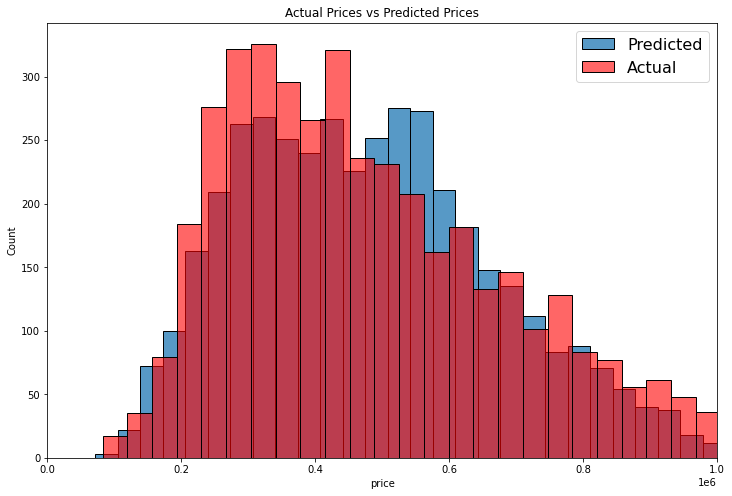

In [233]:
fig , axes = plt.subplots(nrows=1,ncols=1,figsize=(12,8))

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
sns.histplot(y_pred,ax=axes,label='Predicted')
sns.histplot(y_test,color='red',alpha=.6,label='Actual')
axes.set_xlim([0,1000000])
axes.set_xlabel('price')
axes.set_title('Actual Prices vs Predicted Prices')
plt.legend(fontsize=16);

In [231]:
Scaler = StandardScaler()
X_train = Scaler.fit_transform(X_train)
X_test = Scaler.transform(X_test)

final_model = LinearRegression()
final_model.fit(X_train, y_train)

y_pred = final_model.predict(X_test)
final_model.coef_, final_model.intercept_, final_model.score(X_train, y_train), final_model.score(X_test, y_test)

(array([ 95142.66658942,  17476.45355396,  13602.36376869,  -5051.55475776,
        -15911.57071611, -43797.34993214, -68533.90783973, -55258.45760047,
        -18703.77665959,  -2489.42381836,   6574.58043872,   -606.9473909 ,
        101593.85381515,  38359.66315897,    107.49428895]),
 479651.2592592589,
 0.7879803929280698,
 0.7932687439680199)